In [53]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using Test
import Convex as cvx 
import ECOS
using Random
using MathOptInterface

  Activating environment at `c:\Users\chenh\OneDrive\文档\最优控制\HW2_S24-main\Project.toml`


## Note: 

Some of the cells below will have multiple outputs (plots and animations), it can be easier to see everything if you do `Cell -> All Output -> Toggle Scrolling`, so that it simply expands the output area to match the size of the outputs.

## Julia Warnings:

1. For a function `foo(x::Vector)` with 1 input argument, it is not neccessary to do `df_dx = FD.jacobian(_x -> foo(_x), x)`. Instead you can just do `df_dx = FD.jacobian(foo, x)`. If you do the first one, it can dramatically slow down your compliation time. 

2. Do not define functions inside of other functions like this:
```julia
function foo(x)
    # main function foo 
    
    function body(x)
        # function inside function (DON'T DO THIS)
        return 2*x 
    end
    
    return body(x)
end
```
This will also slow down your compilation time dramatically.

# Q1: Finite-Horizon LQR (55 pts)
For this problem we are going to consider a "double integrator" for our dynamics model. This system has a state $x \in \mathbb{R}^4$, and control $u \in \mathbb{R}^2$, where the state describes the 2D position $p$ and velocity $v$ of an object, and the control is the acceleration $a$ of this object.  The state and control are the following:
$$\begin{align} x &= [p_1, p_2, v_1, v_2] \\ u &= [a_1, a_2] \end{align}$$
And the continuous time dynamics for this system are the following:
$$\begin{align} \dot{x} =  \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \end{bmatrix} x + \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1 & 0 \\ 0 & 1 \end{bmatrix} \end{align} u$$

## Part A: Discretize the model (5 pts)

Use the matrix exponential (`exp` in Julia) to discretize the continuous time model assuming we have a zero-order hold on the control. See [this part of the first recitation](https://youtu.be/97JZi5ztc3c?si=Sxqg_uHnRXoozafM&t=2686) if you're unsure of what to do. 

In [54]:
# double integrator dynamics 
function double_integrator_AB(dt)::Tuple{Matrix,Matrix}
    Ac = [0 0 1 0;
          0 0 0 1;
          0 0 0 0;
          0 0 0 0.]
    Bc = [0 0;
          0 0;
          1 0;
          0 1]
    nx, nu = size(Bc)
        
    # TODO: discretize this linear system using the Matrix Exponential
    
    A = zeros(nx,nx) # TODO 
    B = zeros(nx,nu) # TODO 

    matrix_exp = exp([Ac Bc; zeros(nu,nx) zeros(nu,nu)]*dt)

    A = matrix_exp[1:nx, 1:nx]
    B = matrix_exp[1:nx, nx+1:end]

    @assert size(A) == (nx,nx)
    @assert size(B) == (nx,nu)
    
    return A, B 
end

double_integrator_AB (generic function with 1 method)

In [55]:
@testset "discrete time dynamics" begin 
    dt = 0.1 
    A,B = double_integrator_AB(dt)
    
    x = [1,2,3,4.]
    u = [-1,-3.]
    @show A*x+B*u
    @test isapprox((A*x + B*u),[1.295, 2.385, 2.9, 3.7];atol = 1e-10) 
    
end

A * x + B * u = [1.2950000000000002, 2.385, 2.9, 3.7]
Test Summary:          | Pass  Total
discrete time dynamics |    1      1


Test.DefaultTestSet("discrete time dynamics", Any[], 1, false, false)

## Part B: Finite Horizon LQR via Convex Optimization (15 pts)

We are now going to solve the finite horizon LQR problem with convex optimization. As we went over in class, this problem requires $Q \in S_+$(Q is symmetric positive semi-definite) and $R \in S_{++}$ (R is symmetric positive definite).  With this, the optimization problem can be stated as the following:
$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} x_i^TQx_i + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}x_N^TQ_fx_N\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$
 This problem is a convex optimization problem since the cost function is a convex quadratic and the constraints are all linear equality constraints. We will setup and solve this exact problem using the `Convex.jl` modeling package. (See 2/16 Recitation video for help with this package. [Notebook is here](https://github.com/Optimal-Control-16-745/recitations/blob/main/2_17_recitation/Convex.jl_tutorial.ipynb).)  Your job in the block below is to fill out a function `Xcvx,Ucvx = convex_trajopt(A,B,Q,R,Qf,N,x_ic)`, where you will form and solve the above optimization problem. 

In [56]:
# utilities for converting to and from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    # ...用于将变量中的每个元素逐一提取出来
    # hcat 将向量按列组合
    Xm = hcat(X...) 
    return Xm 
end
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end
"""
X,U = convex_trajopt(A,B,Q,R,Qf,N,x_ic; verbose = false)

This function takes in a dynamics model x_{k+1} = A*x_k + B*u_k
and LQR cost Q,R,Qf, with a horizon size N, and initial condition 
x_ic, and returns the optimal X and U's from the above optimization 
problem. You should use the `vec_from_mat` function to convert the 
solution matrices from cvx into vectors of vectors (vec_from_mat(X.value))
"""
function convex_trajopt(A::Matrix,      # A matrix 
                        B::Matrix,      # B matrix 
                        Q::Matrix,      # cost weight 
                        R::Matrix,      # cost weight 
                        Qf::Matrix,     # term cost weight 
                        N::Int64,       # horizon size 
                        x_ic::Vector;   # initial condition
                        verbose = false
                        )::Tuple{Vector{Vector{Float64}},Vector{Vector{Float64}}}
    
    # check sizes of everything 
    nx,nu = size(B)
    @assert size(A) == (nx, nx)
    @assert size(Q) == (nx, nx)
    @assert size(R) == (nu, nu)
    @assert size(Qf) == (nx, nx)
    @assert length(x_ic) == nx
    
    # TODO: 
    
    # create cvx variables where each column is a time step 
    # hint: x_k = X[:,k], u_k = U[:,k]
    X = cvx.Variable(nx, N)
    U = cvx.Variable(nu, N - 1)
    
    # create cost 
    # hint: you can't do x'*Q*x in Convex.jl, you must do cvx.quadform(x,Q)
    # hint: add all of your cost terms to `cost` 
    cost = 0 
    for k = 1:(N-1)
        
        # add stagewise cost 
        cost += 0.5*cvx.quadform(X[:,k], Q)
        cost += 0.5*cvx.quadform(U[:,k], R)
    end

    # add terminal cost 
    cost += 0.5*cvx.quadform(X[:,end], Qf)
    
    # initialize cvx problem 
    prob = cvx.minimize(cost)
    
    # TODO: initial condition constraint 
    prob.constraints += (X[:,1] == x_ic)
    # hint: you can add constraints to our problem like this:
    # prob.constraints += (Gz == h) 
    
    for k = 1:(N-1)
        # dynamics constraints 
        prob.constraints += (X[:,k+1] == A*X[:,k]+B*U[:,k])
    end
    
    # solve problem (silent solver tells us the output)
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = !verbose)
    
    if prob.status != MathOptInterface.OPTIMAL
        error("Convex.jl problem failed to solve for some reason")
    end
        
    # convert the solution matrices into vectors of vectors 
    X = vec_from_mat(X.value) 
    U = vec_from_mat(U.value) 
    
    return X, U 
end     

convex_trajopt

Now let's solve this problem for a given initial condition, and simulate it to see how it does:

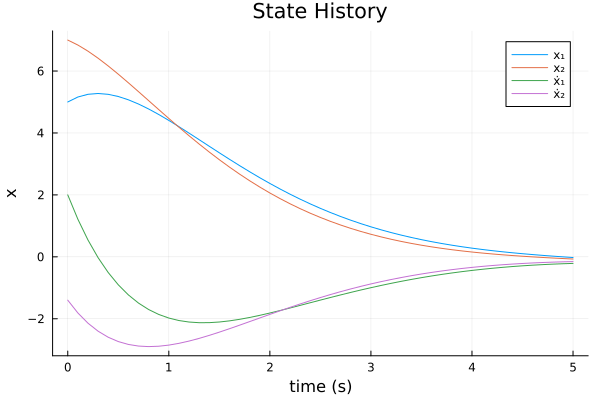

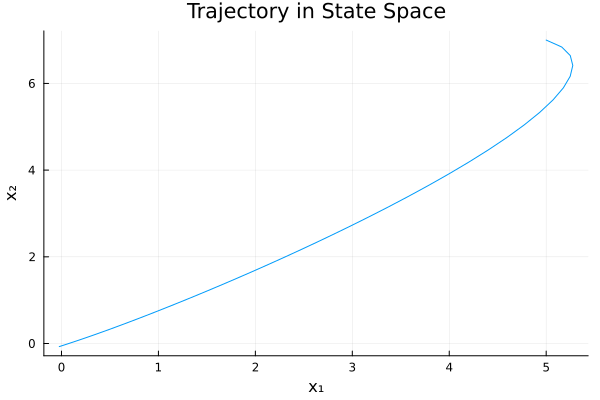

Xsim = [[5.0, 7.0, 2.0, -1.4], [5.160732395747654, 6.839363663509883, 1.2146479149530687, -1.8127267298023382], [5.248616593610927, 6.641567272392372, 0.5430360423123932, -2.1432010925478737], [5.274429914923046, 6.414333449593774, -0.026769616070008162, -2.4014753634240913], [5.2478049677073315, 6.164426653891188, -0.5057293282442883, -2.5966605506276177], [5.17732378093985, 5.897743723475044, -0.9038944071053323, -2.7369980576952817], [5.07060611294715, 5.619397710197908, -1.230458952748676, -2.8299222078474315], [4.9343925721823325, 5.333795571475966, -1.493811862547664, -2.8821205665913956], [4.7746225455955855, 5.044709958955682, -1.701588669187281, -2.8995916838142923], [4.596507028607246, 4.75534539027739, -1.8607216705795038, -2.887699689751547], [4.404596538355376, 4.468399112939508, -1.977488134457907, -2.8512258570060847], [4.202844296633476, 4.186116954751745, -2.057556699980094, -2.7944173067491707], [3.99466486533746, 3.9103444365757225, -2.1060319259402234, -2.7210330567

Test.DefaultTestSet("LQR via Convex.jl", Any[], 6, false, false)

In [57]:
@testset "LQR via Convex.jl" begin 
    
    # problem setup stuff 
    dt = 0.1 
    tf = 5.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    A,B = double_integrator_AB(dt)
    nx,nu = size(B)
    Q = diagm(ones(nx))
    R = diagm(ones(nu))
    Qf = 5*Q 
    
    # initial condition 
    x_ic = [5,7,2,-1.4]
    
    # setup and solve our convex optimization problem (verbose = true for submission)
    Xcvx,Ucvx = convex_trajopt(A,B,Q,R,Qf,N,x_ic; verbose = false) 
    
    # TODO: simulate with the dynamics with control Ucvx, storing the 
    # state in Xsim 
        
    # initial condition 
    Xsim = [zeros(nx) for i = 1:N]
    Xsim[1] = 1*x_ic 

    # TODO dynamics simulation 
    for k = 1:N-1
        Xsim[k+1] = A*Xsim[k] + B*Ucvx[k]
    end
    @show Xsim
    @test length(Xsim) == N 
    @test norm(Xsim[end])>1e-13 
    #----------------------plotting-----------------------
    Xsim_m = mat_from_vec(Xsim)
    
    # plot state history 
    display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "ẋ₁" "ẋ₂"],
                 title = "State History",
                 xlabel = "time (s)", ylabel = "x"))
    
    # plot trajectory in x1 x2 space 
    display(plot(Xsim_m[1,:],Xsim_m[2,:],
                 title = "Trajectory in State Space",
                 ylabel = "x₂", xlabel = "x₁", label = ""))
    #----------------------plotting-----------------------
    
    # tests 
    @test 1e-14 < maximum(norm.(Xsim .- Xcvx,Inf)) < 1e-3
    @test isapprox(Ucvx[1], [-7.8532442316767, -4.127120137234], atol = 1e-3)
    @test isapprox(Xcvx[end], [-0.02285990, -0.07140241, -0.21259, -0.1540299], atol = 1e-3)
    @test 1e-14 < norm(Xcvx[end] - Xsim[end]) < 1e-3
end

### Bellman's Principle of Optimality
Now we will test Bellman's Principle of optimality. This can be phrased in many different ways, but the main gist is that any section of an optimal trajectory must be optimal. Our original optimization problem was the above problem:
$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} x_i^TQx_i + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}x_N^TQ_fx_N\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$
which has a solution $x^*_{1:N},u^*_{1:N-1}$. Now let's look at optimizing over a subsection of this trajectory. That means that instead of solving for $x_{1:N},u_{1:N-1}$, we are now solving for $x_{L:N},u_{L:N-1}$ for some new timestep $1 < L < N$. What we are going to do is take the initial condition from $x^*_L$ from our original optimization problem, and setup a new optimization problem that optimizes over $x_{L:N},u_{L:N-1}$:
$$ \begin{align} \min_{x_{L:N},u_{L:N-1}} \quad & \sum_{i=L}^{N-1} \bigg[ \frac{1}{2} x_i^TQx_i + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}x_N^TQ_fx_N\\ 
 \text{st     } \quad & x_L = x^*_L \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = L,L + 1,\ldots,N-1 
 \end{align}$$

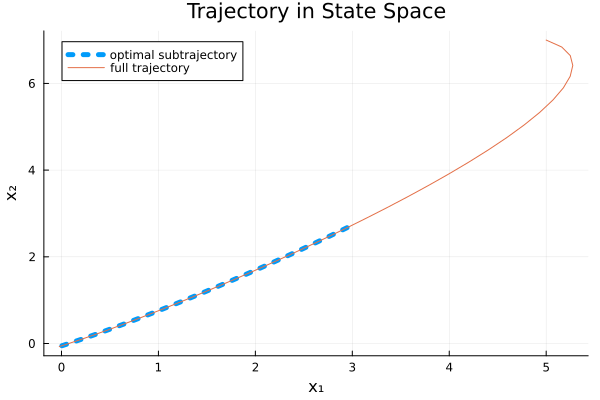

Test Summary:                     | Pass  Total
Bellman's Principle of Optimality |    4      4


Test.DefaultTestSet("Bellman's Principle of Optimality", Any[], 4, false, false)

In [58]:
@testset "Bellman's Principle of Optimality" begin 
    
    # problem setup 
    dt = 0.1 
    tf = 5.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    A,B = double_integrator_AB(dt)
    nx,nu = size(B)
    x0 = [5,7,2,-1.4] # initial condition 
    Q = diagm(ones(nx))
    R = diagm(ones(nu))
    Qf = 5*Q 
    
    # solve for X_{1:N}, U_{1:N-1} with convex optimization
    Xcvx1,Ucvx1 = convex_trajopt(A,B,Q,R,Qf,N,x0; verbose = false)
        
    # now let's solve a subsection of this trajectory 
    L = 18 
    N_2 = N - L + 1
    
    # here is our updated initial condition from the first problem 
    x0_2 = Xcvx1[L]
    Xcvx2,Ucvx2 = convex_trajopt(A,B,Q,R,Qf,N_2,x0_2; verbose = false)
        
    # test if these trajectories match for the times they share 
    U_error = Ucvx1[L:end] .- Ucvx2
    X_error = Xcvx1[L:end] .- Xcvx2
    @test 1e-14 < maximum(norm.(U_error)) < 1e-3
    @test 1e-14 < maximum(norm.(X_error)) < 1e-3


    # ---------------------------plotting ------------------------------
    X1m = mat_from_vec(Xcvx1)
    X2m = mat_from_vec(Xcvx2)
    plot(X2m[1,:],X2m[2,:], label = "optimal subtrajectory", lw = 5, ls = :dot)
    display(plot!(X1m[1,:],X1m[2,:],
                 title = "Trajectory in State Space",
                 ylabel = "x₂", xlabel = "x₁", label = "full trajectory"))
    # ---------------------------plotting ------------------------------
    
    @test isapprox(Xcvx1[end], [-0.02285990, -0.07140241, -0.21259, -0.1540299], rtol = 1e-3)
    @test 1e-14 < norm(Xcvx1[end] - Xcvx2[end],Inf) < 1e-3
end

## Part C: Finite-Horizon LQR via Riccati (10 pts)
Now we are going to solve the original finite-horizon LQR problem:
$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} x_i^TQx_i + \frac{1}{2} u_i^TRu_i \bigg] + \frac{1}{2}x_N^TQ_fx_N\\ 
 \text{st} \quad & x_1 = x_{\text{IC}} \\ 
 & x_{i+1} = A x_i + Bu_i \quad \text{for } i = 1,2,\ldots,N-1 
 \end{align}$$
 with a Riccati recursion instead of convex optimization. We describe our optimal cost-to-go function (aka the Value function) as the following:
 
 $$V_k(x) = \frac{1}{2}x^TP_kx$$.

In [59]:
"""
use the Riccati recursion to calculate the cost to go quadratic matrix P and 
optimal control gain K at every time step. Return these as a vector of matrices, 
where P_k = P[k], and K_k = K[k]
"""
function fhlqr(A::Matrix, # A matrix 
               B::Matrix, # B matrix 
               Q::Matrix, # cost weight 
               R::Matrix, # cost weight 
               Qf::Matrix,# term cost weight 
               N::Int64   # horizon size 
               )::Tuple{Vector{Matrix{Float64}}, Vector{Matrix{Float64}}} # return two matrices 
        
    # check sizes of everything 
    nx,nu = size(B)
    @assert size(A) == (nx, nx)
    @assert size(Q) == (nx, nx)
    @assert size(R) == (nu, nu)
    @assert size(Qf) == (nx, nx)
        
    # instantiate S and K 
    P = [zeros(nx,nx) for i = 1:N]
    K = [zeros(nu,nx) for i = 1:N-1]
    
    # initialize S[N] with Qf 
    P[N] = deepcopy(Qf)
    
    # Riccati
    for k = N-1:-1:1
        # TODO 
        K[k] = inv((R+B'*P[k+1]*B))*B'*P[k+1]*A
        P[k] = Q + A'*P[k+1]*(A-B*K[k])
    end
    
    return P, K 
end

fhlqr

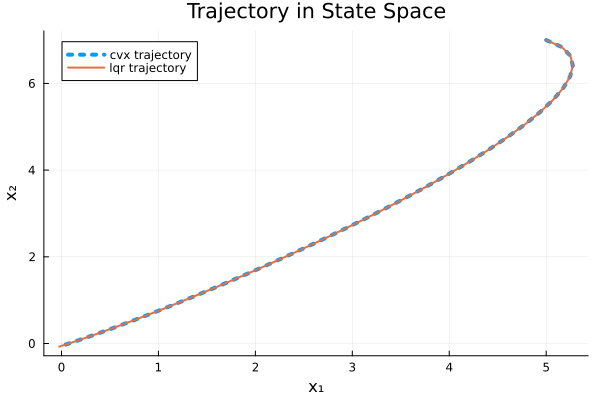

Test Summary:         | Pass  Total
Convex trajopt vs LQR |    3      3


Test.DefaultTestSet("Convex trajopt vs LQR", Any[], 3, false, false)

In [60]:
@testset "Convex trajopt vs LQR" begin 
    
    # problem stuff
    dt = 0.1 
    tf = 5.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    A,B = double_integrator_AB(dt)
    nx,nu = size(B)
    x0 = [5,7,2,-1.4] # initial condition 
    Q = diagm(ones(nx))
    R = diagm(ones(nu))
    Qf = 5*Q 
    
    # solve for X_{1:N}, U_{1:N-1} with convex optimization
    Xcvx,Ucvx = convex_trajopt(A,B,Q,R,Qf,N,x0; verbose = false)
    P, K = fhlqr(A,B,Q,R,Qf,N)
    # now let's simulate using Ucvx 
    Xsim_cvx = [zeros(nx) for i = 1:N]
    Xsim_cvx[1] = 1*x0 
    Xsim_lqr = [zeros(nx) for i = 1:N]
    Xsim_lqr[1] = 1*x0 
    for i = 1:N-1
        # simulate cvx control 
        Xsim_cvx[i+1] = A*Xsim_cvx[i] + B*Ucvx[i]
        
        # TODO: use your FHLQR control gains K to calculate u_lqr
        # simulate lqr control 
        # u_lqr = zeros(2)
        u_lqr = -K[i]*Xsim_lqr[i]
        Xsim_lqr[i+1] = A*Xsim_lqr[i] + B*u_lqr
    end
    

    @test isapprox(Xsim_lqr[end], [-0.02286201, -0.0714058, -0.21259, -0.154030], rtol = 1e-3)
    @test 1e-13 < norm(Xsim_lqr[end] - Xsim_cvx[end]) < 1e-3
    @test 1e-13 < maximum(norm.(Xsim_lqr - Xsim_cvx)) < 1e-3

    
    # ------------------------plotting--------------------------
    X1m = mat_from_vec(Xsim_cvx)
    X2m = mat_from_vec(Xsim_lqr)
    # plot trajectory in x1 x2 space 
    plot(X1m[1,:],X1m[2,:], label = "cvx trajectory", lw = 4, ls = :dot)
    display(plot!(X2m[1,:],X2m[2,:],
                 title = "Trajectory in State Space",
                 ylabel = "x₂", xlabel = "x₁", lw = 2, label = "lqr trajectory"))
    # ------------------------plotting--------------------------

end

To emphasize that these two methods for solving the optimization problem result in the same solutions, we are now going to sample initial conditions and run both solutions. You will have to fill in your LQR policy again. 

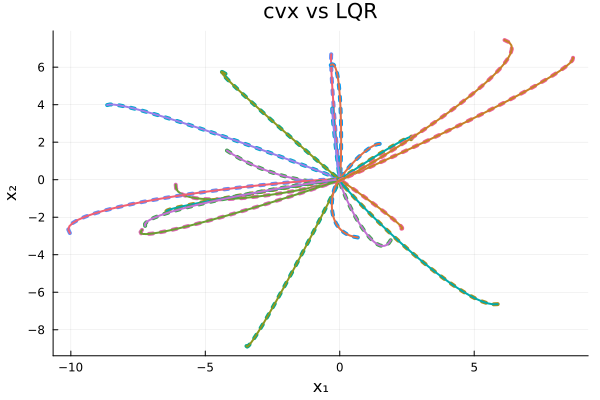

Test Summary:         | Pass  Total
Convex trajopt vs LQR |   40     40


Test.DefaultTestSet("Convex trajopt vs LQR", Any[], 40, false, false)

In [61]:
import Random 
Random.seed!(1)
@testset "Convex trajopt vs LQR" begin 
    
    # problem stuff
    dt = 0.1 
    tf = 5.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    A,B = double_integrator_AB(dt)
    nx,nu = size(B)
    Q = diagm(ones(nx))
    R = diagm(ones(nu))
    Qf = 5*Q 
    
    
    plot()
    for ic_iter = 1:20
        x0 = [5*randn(2); 1*randn(2)]
        # solve for X_{1:N}, U_{1:N-1} with convex optimization
        Xcvx,Ucvx = convex_trajopt(A,B,Q,R,Qf,N,x0; verbose = false)
        P, K = fhlqr(A,B,Q,R,Qf,N)
        Xsim_cvx = [zeros(nx) for i = 1:N]
        Xsim_cvx[1] = 1*x0 
        Xsim_lqr = [zeros(nx) for i = 1:N]
        Xsim_lqr[1] = 1*x0 
        for i = 1:N-1
            # simulate cvx control 
            Xsim_cvx[i+1] = A*Xsim_cvx[i] + B*Ucvx[i]

            # TODO: use your FHLQR control gains K to calculate u_lqr
            # simulate lqr control 
            # u_lqr = zeros(2)
            u_lqr = -K[i]*Xsim_lqr[i]
            Xsim_lqr[i+1] = A*Xsim_lqr[i] + B*u_lqr
        end

        @test 1e-13 < norm(Xsim_lqr[end] - Xsim_cvx[end]) < 1e-3
        @test 1e-13 < maximum(norm.(Xsim_lqr - Xsim_cvx)) < 1e-3
        
        # ------------------------plotting--------------------------
        X1m = mat_from_vec(Xsim_cvx)
        X2m = mat_from_vec(Xsim_lqr)
        plot!(X2m[1,:],X2m[2,:], label = "", lw = 4, ls = :dot)
        plot!(X1m[1,:],X1m[2,:], label = "", lw = 2)
    end
    display(plot!(title = "cvx vs LQR", ylabel = "x₂", xlabel = "x₁"))

end

## Part D: Why LQR is so great (10 pts)

Now we are going to emphasize two reasons why the feedback policy from LQR is so useful:

1. It is robust to noise and model uncertainty (the Convex approach would require re-solving of the problem every time the new state differs from the expected state (this is MPC, more on this in Q3)
2. We can drive to any achievable goal state with $u = -K(x - x_{goal})$

First we are going to look at a simulation with the following white noise:
$$x_{k+1} = Ax_k + Bu_k + \text{noise}$$
Where noise $ \sim \mathcal{N}(0,\Sigma)$.

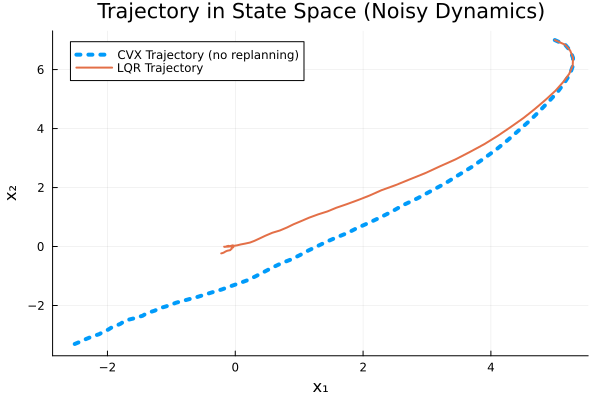

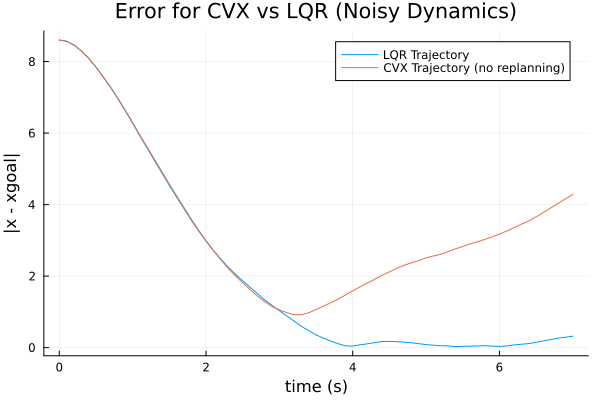

Test Summary:             | Pass  Total
Why LQR is great reason 1 |    3      3


Test.DefaultTestSet("Why LQR is great reason 1", Any[], 3, false, false)

In [62]:
@testset "Why LQR is great reason 1" begin 
    
    # problem stuff
    dt = 0.1 
    tf = 7.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    A,B = double_integrator_AB(dt)
    nx,nu = size(B)
    x0 = [5,7,2,-1.4] # initial condition 
    Q = diagm(ones(nx))
    R = diagm(ones(nu))
    Qf = 10*Q 
    
    # solve for X_{1:N}, U_{1:N-1} with convex optimization
    Xcvx,Ucvx = convex_trajopt(A,B,Q,R,Qf,N,x0; verbose = false)
    P, K = fhlqr(A,B,Q,R,Qf,N)
    # now let's simulate using Ucvx 
    Xsim_cvx = [zeros(nx) for i = 1:N]
    Xsim_cvx[1] = 1*x0 
    Xsim_lqr = [zeros(nx) for i = 1:N]
    Xsim_lqr[1] = 1*x0 
    for i = 1:N-1
        # sampled noise to be added after each step 
        noise = [.005*randn(2);.1*randn(2)]
        
        # simulate cvx control 
        Xsim_cvx[i+1] = A*Xsim_cvx[i] + B*Ucvx[i] + noise
        
        # TODO: use your FHLQR control gains K to calculate u_lqr
        # simulate lqr control 
        # u_lqr = zeros(2)
        u_lqr = -K[i]*Xsim_lqr[i]
        Xsim_lqr[i+1] = A*Xsim_lqr[i] + B*u_lqr + noise
    end
    
    # make sure our LQR achieved the goal 
    @test norm(Xsim_cvx[end]) > norm(Xsim_lqr[end])
    @test norm(Xsim_lqr[end]) < .7
    @test norm(Xsim_cvx[end]) > 2.0
    
    
    # ------------------------plotting--------------------------
    X1m = mat_from_vec(Xsim_cvx)
    X2m = mat_from_vec(Xsim_lqr)
    # plot trajectory in x1 x2 space 
    plot(X1m[1,:],X1m[2,:], label = "CVX Trajectory (no replanning)", lw = 4, ls = :dot)
    display(plot!(X2m[1,:],X2m[2,:],
                 title = "Trajectory in State Space (Noisy Dynamics)",
                 ylabel = "x₂", xlabel = "x₁", lw = 2, label = "LQR Trajectory"))
    ecvx = [norm(x[1:2]) for x in Xsim_cvx]
    elqr = [norm(x[1:2]) for x in Xsim_lqr]
    plot(t_vec, elqr, label = "LQR Trajectory",ylabel = "|x - xgoal|",
         xlabel = "time (s)", title = "Error for CVX vs LQR (Noisy Dynamics)")
    display(plot!(t_vec, ecvx, label = "CVX Trajectory (no replanning)"))
    # ------------------------plotting--------------------------

end

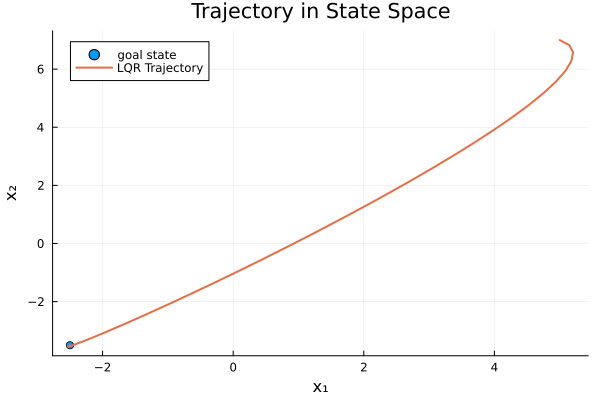

Test Summary:             | Pass  Total
Why LQR is great reason 2 |    3      3


Test.DefaultTestSet("Why LQR is great reason 2", Any[], 3, false, false)

In [63]:
@testset "Why LQR is great reason 2" begin 
    
    # problem stuff
    dt = 0.1 
    tf = 20.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    A,B = double_integrator_AB(dt)
    nx,nu = size(B)
    x0 = [5,7,2,-1.4] # initial condition 
    Q = diagm(ones(nx))
    R = diagm(ones(nu))
    Qf = 10*Q 
    
    P, K = fhlqr(A,B,Q,R,Qf,N)
    
    # TODO: specify a goal state with 0 velocity within a 5m radius of 0 
    xgoal = [-2.5,-3.5,0,0]
    @test norm(xgoal[1:2])< 5
    @test norm(xgoal[3:4])<1e-13 # ensure 0 velocity

    Xsim_lqr = [zeros(nx) for i = 1:N]
    Xsim_lqr[1] = 1*x0 
    
    ugoal = B\(Diagonal(ones(nx))-A)*xgoal
    for i = 1:N-1
        # TODO: use your FHLQR control gains K to calculate u_lqr
        # simulate lqr control 
        # u_lqr = zeros(2)
        u_lqr = ugoal-K[i]*(Xsim_lqr[i]-xgoal)
        Xsim_lqr[i+1] = A*Xsim_lqr[i] + B*u_lqr
    end
    
    @test norm(Xsim_lqr[end][1:2] - xgoal[1:2]) < .1 
    
    # ------------------------plotting--------------------------
    Xm = mat_from_vec(Xsim_lqr)
    plot(xgoal[1:1],xgoal[2:2],seriestype = :scatter, label = "goal state")
    display(plot!(Xm[1,:],Xm[2,:],
                 title = "Trajectory in State Space",
                 ylabel = "x₂", xlabel = "x₁", lw = 2, label = "LQR Trajectory"))


end

## Part E: Infinite-horizon LQR (10 pts)
Up until this point, we have looked at finite-horizon LQR which only considers a finite number of timesteps in our trajectory.  When this problem is solved with a Riccati recursion, there is a new feedback gain matrix $K_k$ for each timestep. As the length of the trajectory increases, the first feedback gain matrix $K_1$ will begin to converge on what we call the "infinite-horizon LQR gain".  This is the value that $K_1$ converges to as $N \rightarrow \infty$.

Below, we will plot the values of $P$ and $K$ throughout the horizon and observe this convergence. 

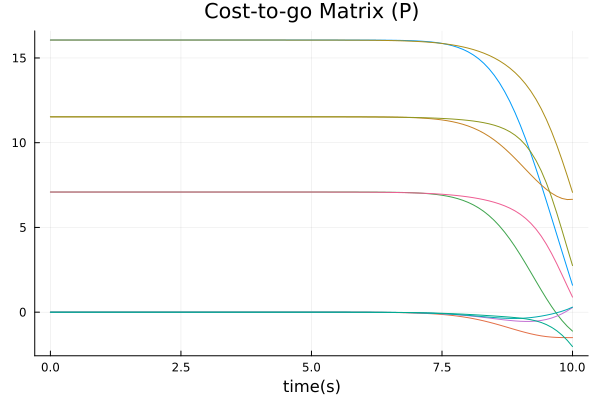

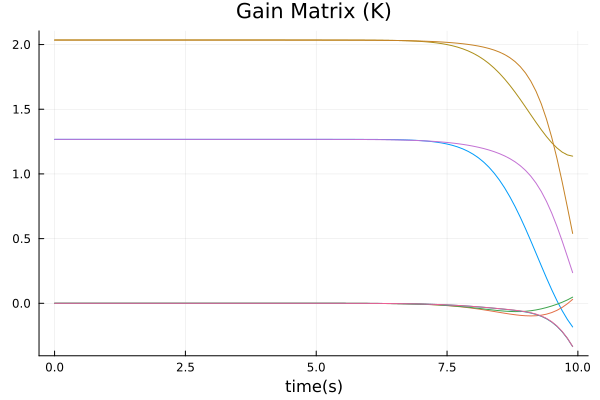

Test Summary:         | Pass  Total
P and K time analysis |    2      2


Test.DefaultTestSet("P and K time analysis", Any[], 2, false, false)

In [64]:
# half vectorization of a matrix 
# 生成矩阵A的下三角布尔掩码
# tril 提取矩阵的下三角
# trues(size(A)) 创建和矩阵A维度一致的布尔矩阵，全为true
function vech(A)
    return A[tril(trues(size(A)))]
end
@testset "P and K time analysis" begin 
    
    # problem stuff
    dt = 0.1 
    tf = 10.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    A,B = double_integrator_AB(dt)
    nx,nu = size(B)
    
    # cost terms 
    Q = diagm(ones(nx))
    R = .5*diagm(ones(nu))
    Qf = randn(nx,nx); Qf = Qf'*Qf + I;
    
    P, K = fhlqr(A,B,Q,R,Qf,N)
    
    Pm = hcat(vech.(P)...)  # 对P每个矩阵进行半矢量化操作，提取下三角
    Km = hcat(vec.(K)...)   # 对K每个矩阵进行完全矢量化操作，提取矩阵所有元素
    
    # make sure these things converged 
    @test 1e-13 < norm(P[1] - P[2]) < 1e-3 
    @test 1e-13 < norm(K[1] - K[2]) < 1e-3

    display(plot(t_vec, Pm', label = "",title = "Cost-to-go Matrix (P)", xlabel = "time(s)"))
    display(plot(t_vec[1:end-1], Km', label = "",title = "Gain Matrix (K)", xlabel = "time(s)"))

    
end

Complete this infinite horizon LQR function where you do a Riccati recursion until the cost to go matrix P converges:

$$ \|P_k - P_{k+1}\| \leq \text{tol}$$

And return the steady state $P$ and $K$. 

In [65]:
"""
P,K = ihlqr(A,B,Q,R)

TODO: complete this infinite horizon LQR function where 
you do the Riccati recursion until the cost to go matrix 
P converges to a steady value |P_k - P_{k+1}| ≤ tol 
"""
function ihlqr(A::Matrix,       # vector of A matrices 
               B::Matrix,       # vector of B matrices
               Q::Matrix,       # cost matrix Q 
               R::Matrix;       # cost matrix R 
               max_iter = 1000, # max iterations for Riccati
               tol = 1e-5       # convergence tolerance
               )::Tuple{Matrix, Matrix} # return two matrices 
        
    # get size of x and u from B 
    nx, nu = size(B)
        
    # initialize S with Q
    P = deepcopy(Q)
    
    # Riccati 
    for riccati_iter = 1:max_iter 

        # TODO 
        P_1 = P
        K = inv((R+B'*P*B))*B'*P*A
        P = Q + A'*P*(A-B*K)
        if(norm(P-P_1) <= tol)
            return P, K
        end
    end
    error("ihlqr did not converge")
end
@testset "ihlqr test" begin 
    # problem stuff
    dt = 0.1 
    A,B = double_integrator_AB(dt)
    nx,nu = size(B)
    
    # we're just going to modify the system a little bit 
    # so the following graphs are still interesting

    Q = diagm(ones(nx))
    R = .5*diagm(ones(nu))
    P, K = ihlqr(A,B,Q,R)
    
    # check this P is in fact a solution to the Riccati equation
    @test typeof(P) == Matrix{Float64} 
    @test typeof(K) == Matrix{Float64}
    @test 1e-13 < norm(Q + K'*R*K + (A - B*K)'P*(A - B*K) - P) < 1e-3
    
end

Test Summary: | Pass  Total
ihlqr test    |    3      3


Test.DefaultTestSet("ihlqr test", Any[], 3, false, false)

## Part F (5 pts): One sentence short answer

1. What is the difference between stage cost and terminal cost?

**Stage cost is a cost that applies to timesteps 1:N-1 and takes (x,u) as inputs, where the terminal cost only applies to timestep N and takes (x) as an input.**

2. What is a terminal cost trying to capture? (think about dynamic programming)

**The terminal cost is trying to capture the cost-to-go (value function). If our terminal cost was the true cost-to-go, we would get optimal actions even if our horizon length was only 1 step. In general, we make our horizon length longer to make up for the fact that our terminal cost is usually not an exact replacement for our cost-to-go.**

3. In order to build an LQR controller for a linear system, do we need to know the initial state $x_0$?

**No, we build our LQR system with (A,B,Q,R). There is no dependence on x0.**

4. If a linear system is uncontrollable, will the finite-horizon LQR convex optimization problem have a solution?

**Yes, even if the linear system is uncontrollable, the convex optimization problem is still convex, feasible, and solvable.**